Timing Image Segmentation

A notebook intended to be modular enough that we can refine the segmentation and cell counting methods, and distill the essential controlling parameters. 
Ultimately these parameters and functions will be in the main module, and set either in the config file, OR provdied on a sample-by-sample basis.

In [2]:
#Imports
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm

import concurrent.futures
import time

from skimage import io, transform
from skimage.util import img_as_float32

# Module imports
import sys
sys.path.append('E://Documents/Professional/Jupyter notebooks/Projects/Iordonova_lab/')
# sys.path.append('brain_segmentations')

from brain_segmentations.config import *
from brain_segmentations.preprocessing.file_io import *
from brain_segmentations.segmentation.segmentation import *


experiment_folder defined in config. Be careful in the future! Iordanova_06082022_SOC-R9-F_NeuN-cFOS/


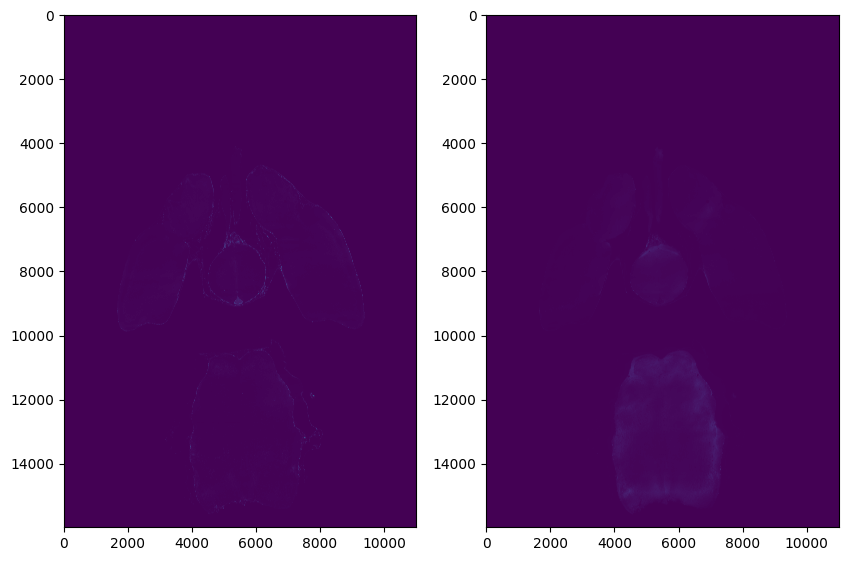

In [3]:
# Start by selecting and loading an image at random from the dataset

fullres_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/561nm_NeuN/'
fos_folder = 'Z://Collaboration_data/Iordonova_lab/Iordanova_06082022_SOC-R9-F_NeuN-cFOS/647nm_cFOS/'

# Get a list of all tif files in the folder 
identifiers = [f[:-4] for f in os.listdir(fullres_folder) if f.endswith('.tif')]

# Select a random identifier
identifier = np.random.choice(identifiers)

# Load the image
img = io.imread(fullres_folder + identifier + '.tif')

# Load the fos image
fos_img = io.imread(fos_folder + identifier + '.tif')

# Show the loaded images
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(fos_img)
plt.show()

356850_415210_055320


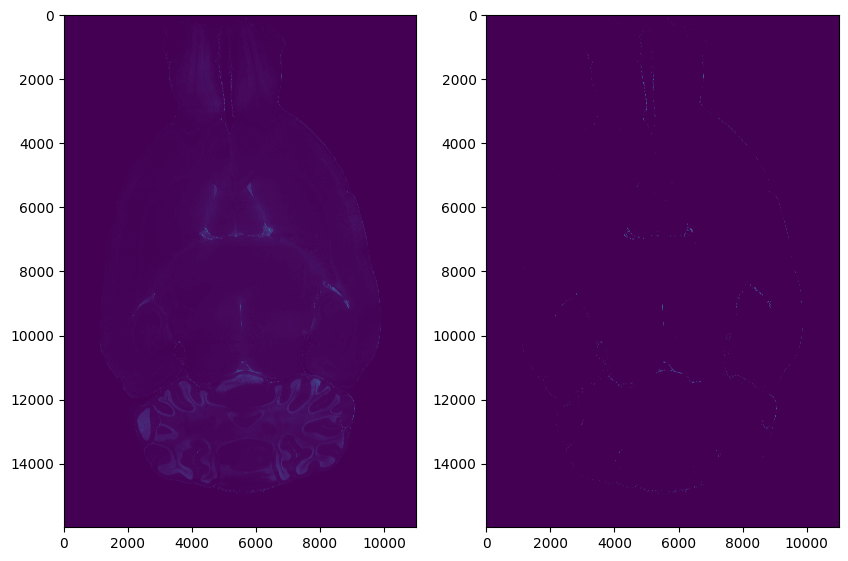

In [4]:
# Get an example identifier halfway through the list
example_identifier = identifiers[len(identifiers) // 2]

print(example_identifier)

# Load this image
full_img = io.imread(fullres_folder + example_identifier + '.tif')

# Compare the timing per image for the full image segmentations versus the gridded approach

# # Full image segmentation
# start_time = time.time()
# top_hat_transformed = top_hat_transform(full_img)
# seg_img, pos = segment_image(top_hat_transformed)
# end_time = time.time()
# full_image_time = end_time - start_time

# # Plot the results
# fig, ax = plt.subplots(1,2, figsize=(10,10))
# ax[0].imshow(full_img)
# ax[1].imshow(seg_img)
# plt.show()


Full image load time: 1.91 seconds
500
Multithreaded gridded segmentation time: 170.25 seconds
Multithreaded gridded segmentation time: 131.25 seconds
1000
Multithreaded gridded segmentation time: 94.40 seconds
Multithreaded gridded segmentation time: 51.12 seconds
2000
Multithreaded gridded segmentation time: 63.22 seconds
Multithreaded gridded segmentation time: 16.06 seconds
4000
Multithreaded gridded segmentation time: 42.61 seconds
Multithreaded gridded segmentation time: 6.65 seconds
8000
Multithreaded gridded segmentation time: 42.40 seconds
Multithreaded gridded segmentation time: 7.75 seconds
10000
Multithreaded gridded segmentation time: 42.13 seconds
Multithreaded gridded segmentation time: 7.62 seconds


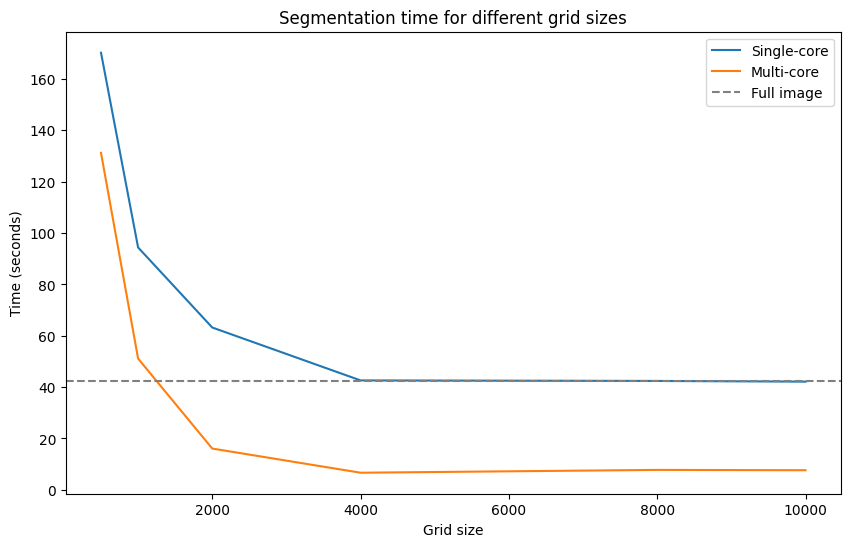

In [5]:
# Define a function to process a single crop
def process_crop(crop):
    top_hat_transformed = top_hat_transform(crop)
    seg_img, pos = segment_image(top_hat_transformed)

# Define the range of grid sizes to test
grid_sizes = [500, 1000, 2000, 4000, 8000, 10000]

# Define a list to store the times for each grid size
times_single_core = []
times_multi_core = []

start_time = time.time()
# Load this image
full_img = io.imread(fullres_folder + example_identifier + '.tif')
end_time = time.time()
load_time = end_time - start_time
print(f"Full image load time: {load_time:.2f} seconds")

# # Full image segmentation
# start_time = time.time()

# top_hat_transformed = top_hat_transform(full_img)
# seg_img, pos = segment_image(top_hat_transformed)

# end_time = time.time()
# full_image_time = end_time - start_time
# print(f"Full image segmentation time: {full_image_time:.2f} seconds")

for grid_size in grid_sizes:

    # Gridded segmentation - single core
    start_time = time.time()
    crop_list = crop_image(full_img, crop_size=(grid_size, grid_size), mode='grid')
    for this_crop in crop_list:
        process_crop(this_crop)
    end_time = time.time()  
    times_single_core.append(end_time - start_time)
    print(grid_size)
    print(f"Multithreaded gridded segmentation time: {times_single_core[-1]:.2f} seconds")

    # # Gridded segmentation - multi-core
    # start_time = time.time()
    # crop_list = crop_image(full_img, crop_size=(grid_size, grid_size), mode='grid')
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #     executor.map(process_crop, crop_list)
    # end_time = time.time()  
    # times_multi_core.append(end_time - start_time)

    # Multithreaded gridded segmentation
    start_time = time.time()
    crop_list = crop_image(full_img, crop_size=(grid_size, grid_size), mode='grid')

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_results = [executor.submit(segment_image, crop) for crop in crop_list]
        for future in concurrent.futures.as_completed(future_results):
            seg_img, pos = future.result()
    end_time = time.time()
    
    times_multi_core.append(end_time - start_time)
    print(f"Multithreaded gridded segmentation time: {times_multi_core[-1]:.2f} seconds")



    # print(grid_size, times_multi_core[-1])
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, times_single_core, label='Single-core')
plt.plot(grid_sizes, times_multi_core, label='Multi-core')
plt.axhline(y=full_image_time, color='gray', linestyle='--', label='Full image')
plt.xlabel('Grid size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Segmentation time for different grid sizes')
plt.show()


In [ ]:
crop_list = crop_image(full_img, crop_size=(grid_size, grid_size), mode='grid')

# Gridded segmentation - multi-core
start_time = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(process_crop, crop_list)
end_time = time.time()  
times_multi_core.append(end_time - start_time)
times_multi_core



[0.8518922328948975, 0.7410938739776611]

In [ ]:
'''To replace crop_image in segmentation.py'''

# def crop_image(image, crop_size, mode='random', overlap=0):
#     height, width = image.shape
#     crop_height, crop_width = crop_size

#     if mode == 'random':
#         start_y = np.random.randint(0, height - crop_height + 1)
#         start_x = np.random.randint(0, width - crop_width + 1)

#         cropped_image = image[start_y : start_y + crop_height, start_x : start_x + crop_width]

#     elif mode == 'grid':
#         grid_height = (height - crop_height) // (crop_height - overlap) + 1
#         grid_width = (width - crop_width) // (crop_width - overlap) + 1

#         cropped_images = []

#         for i in range(grid_height):
#             for j in range(grid_width):
#                 start_y = i * (crop_height - overlap)
#                 start_x = j * (crop_width - overlap)

#                 # Check if we are at the last cell of the grid in y or x direction
#                 # If so, ensure we don't exceed the image boundaries
#                 if i == grid_height - 1:
#                     end_y = height
#                 else:
#                     end_y = start_y + crop_height

#                 if j == grid_width - 1:
#                     end_x = width
#                 else:
#                     end_x = start_x + crop_width

#                 cropped_image = image[start_y:end_y, start_x:end_x]
#                 cropped_images.append(cropped_image)

#         # Test to check that the sum of areas of all crops is equal to the area of the original image
#         assert np.sum([crop.size for crop in cropped_images]) == image.size

#         return cropped_images

#     else:
#         raise ValueError("Invalid mode specified. Choose either 'random' or 'grid'.")

    # return cropped_image


Full image segmentation time: 42.76 seconds
Gridded segmentation time for grid size (100, 100): 232.58 seconds
Gridded segmentation time for grid size (500, 500): 176.02 seconds
Gridded segmentation time for grid size (1000, 1000): 98.12 seconds
Gridded segmentation time for grid size (2000, 2000): 64.47 seconds
Gridded segmentation time for grid size (4000, 4000): 43.12 seconds
Gridded segmentation time for grid size (6000, 6000): 42.37 seconds
Gridded segmentation time for grid size (8000, 8000): 42.81 seconds
Gridded segmentation time for grid size (10000, 10000): 43.17 seconds


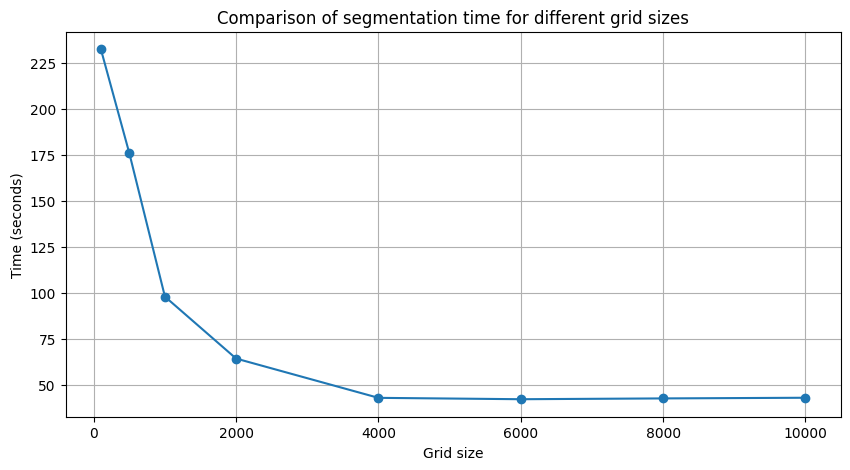

In [ ]:
# Define the grid sizes to test
grid_sizes = [(100, 100),
              (500, 500), 
              (1000, 1000), 
              (2000, 2000), 
              (4000, 4000), 
              (6000, 6000), 
              (8000, 8000), 
              (10000, 10000)]

# Store the times for each grid size
times = []

# Get an example identifier halfway through the list
example_identifier = identifiers[len(identifiers) // 2]

# Load this image
full_img = io.imread(fullres_folder + example_identifier + '.tif')

# Full image segmentation
start_time = time.time()
top_hat_transformed = top_hat_transform(full_img)
seg_img, pos = segment_image(top_hat_transformed)
end_time = time.time()
full_image_time = end_time - start_time
print(f"Full image segmentation time: {full_image_time:.2f} seconds")

# Loop over each grid size
for grid_size in grid_sizes:
    # Gridded segmentation
    start_time = time.time()
    crop_list = crop_image(full_img, crop_size=grid_size, mode='grid')
    for this_crop in crop_list:
        top_hat_transformed = top_hat_transform(this_crop)
        seg_img, pos = segment_image(top_hat_transformed)
    end_time = time.time()  
    gridded_time = end_time - start_time
    times.append(gridded_time)
    print(f"Gridded segmentation time for grid size {grid_size}: {gridded_time:.2f} seconds")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot([size[0] for size in grid_sizes], times, marker='o')
plt.xlabel('Grid size')
plt.ylabel('Time (seconds)')
plt.title('Comparison of segmentation time for different grid sizes')
plt.grid(True)
plt.show()


In [ ]:
len(crop_list)

1

In [ ]:
crop_list[0].shape

(15988, 10999)

In [ ]:
# import concurrent.futures

# # Define the grid size to test
# grid_size = (1000, 1000)

# # Get an example identifier halfway through the list
# example_identifier = identifiers[len(identifiers) // 2]

# # Load this image
# full_img = io.imread(fullres_folder + example_identifier + '.tif')

# # Full image segmentation
# start_time = time.time()
# top_hat_transformed = top_hat_transform(full_img)
# seg_img, pos = segment_image(top_hat_transformed)
# end_time = time.time()
# full_image_time = end_time - start_time
# print(f"Full image segmentation time: {full_image_time:.2f} seconds")   

# Gridded segmentation
start_time = time.time()
crop_list = crop_image(full_img, crop_size=grid_size, mode='grid')
for this_crop in crop_list:
    top_hat_transformed = top_hat_transform(this_crop)
    seg_img, pos = segment_image(top_hat_transformed)
end_time = time.time()  
gridded_time = end_time - start_time
print(f"Gridded segmentation time: {gridded_time:.2f} seconds")

# Multithreaded gridded segmentation
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_results = [executor.submit(segment_image, crop) for crop in crop_list]
    for future in concurrent.futures.as_completed(future_results):
        seg_img, pos = future.result()
end_time = time.time()
multithreaded_time = end_time - start_time
print(f"Multithreaded gridded segmentation time: {multithreaded_time:.2f} seconds")


Full image segmentation time: 42.98 seconds
Gridded segmentation time: 88.68 seconds
Multithreaded gridded segmentation time: 51.24 seconds


In [ ]:
''' Original testing version combined thresolding and regionprops'''
def segment_image(image, method='otsu', custom_threshold=None):
    
    # Threshold the image
    if method == 'otsu':
        threshold = skimage.filters.threshold_otsu(image)
    elif method == 'mean':
        threshold = np.mean(image)
    elif method == 'custom':
        if custom_threshold is not None:
            threshold = custom_threshold
        else:
            raise ValueError("Please provide a custom threshold value.")
    else:
        raise ValueError("Invalid method specified. Choose either 'otsu', 'mean', or 'custom'.")

    segmented_image = image > threshold
    labeled_image = skimage.measure.label(segmented_image)
    properties = regionprops_table(labeled_image, properties=('centroid',))
    positions = np.column_stack([properties['centroid-0'], properties['centroid-1']])

    return segmented_image, positions


In [12]:
# # We want separate functions to do the thresholding and regionprops
# def threshold_image(image, method='otsu', custom_threshold=None):
        
#         # Threshold the image
#         if method == 'otsu':
#             threshold = skimage.filters.threshold_otsu(image)
#         elif method == 'mean':
#             threshold = np.mean(image)
#         elif method == 'custom':
#             if custom_threshold is not None:
#                 threshold = custom_threshold
#             else:
#                 raise ValueError("Please provide a custom threshold value.")
#         else:
#             raise ValueError("Invalid method specified. Choose either 'otsu', 'mean', or 'custom'.")
    
#         thresholded_image = image > threshold

#         # make sure the image is binary
#         thresholded_image = thresholded_image.astype(int)

#         return thresholded_image


# def label_image(thresholded_image):   

#     # Assert the image is binary (already thresholded)
#     assert np.all(np.unique(thresholded_image) == [0, 1]), "Image is not binary." 
    
#     # Apply regionprops to extract the positions
#     labeled_image = skimage.measure.label(thresholded_image)
#     properties = regionprops_table(labeled_image, properties=('centroid',))
#     positions = np.column_stack([properties['centroid-0'], properties['centroid-1']])
    
#     return labeled_image, positions




Try new order: load, threshold/segment (whole), then apply region mask and count.  

In [ ]:
# For the thresholded image